# Cutout failures: diaSource outside bbox

## Table of Contents

1. [Introduction](#Introduction)
2. [Conclusions](#Conclusions)
3. [Setup](#Setup)
4. [Sources One](#Sources-One)
5. [Sources Two](#Sources-Two)
6. [Source Three](#Source-Three)
7. [Source Four](#Source-Four)
8. [Source Five](#Source-Five)
9. [Looking at Bounding Boxes](#Looking-at-Bounding-Boxes)
10. [Filters](#Filters)

## Introduction

This notebook looks at a set of sources which have centroids off the chip. This notebook was used to look at them and identify common threads between the bad sources and if we can simply determine them as unusable and remove them from the list of good sources. All of the sources only have dipole information and no psf information.

## Conclusions

Upon further investigation of the footprints, we found that the footprint location was not centered on the source location. These can be seen when looking at the the SourceRecord and both base_SdssCentroid and base_PeakCentroid. The footprint location is from the the base_PeakCentroid, while the source location is from the base_SdssCentroid, and are wildly different. This is a result of the maxDistToPeak being set to -1 in 
CentroidUtilities.CentroidChecker. DM-38285 will experiment with using the max distance to explore if this fixes the issue, and also how this impacts detected sources.

If we were to only look at the SdssCentroid, there are no associated sources since the two centroids are so wildly different. However, looking at the footprint does reveal that at least one source was a real source. This likely means that we should use the footprint to try and diagnose some of these issues, as the listed source position is not necessarily the same. This may be fixed by adjusting maxDistToPeak.

The last two sections, Looking at Bounding Boxes and Filters, are not particularly relevant anymore now that we are specifically looking at the footprints and have identified the mismatch between the PeakCentroid and SdssCentroid.

## Setup

In [1]:
# Basic imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
from IPython.display import Image, display

from astropy.coordinates import SkyCoord

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import ZooniverseCutoutsTask
from lsst.analysis.ap.nb_utils import make_simbad_link
from lsst.analysis.ap import apdb


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

bandList = ['i', 'z', 'y']
colorList = ['C2', 'C3', 'C5', 'k']
import lsst.afw.display as afwDisplay
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import gc


afwDisplay.setDefaultBackend('matplotlib') 

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [3]:
def m_and_v_plots (exposure, matplot=None, display_num=None):
    """
    Create an array of plots with their mask and variance

    Parameters
    ----------
    datasetRefs: a set of DataSetRefs
    returned by the butler
    matplot: Can be set to True
    display_num: Integer setting number of images

    Returns
    -------
    None
    """
    
    if display_num == None:
        display_num=1
    else:
        display_num=display_num
    
    if matplot != None:
        afwDisplay.setDefaultBackend('matplotlib') 
        
        print('Visit: ', exposure.visitInfo.getId(), ', Detector: ', exposure.detector.getId())
        fig, ax = plt.subplots(1, 3, figsize=(14, 7))
        plt.sca(ax[0])  # set the first axis as current
        plt.xlabel('Image with Mask Overlay')
        display1 = afwDisplay.Display(frame=fig)
        display1.scale('asinh', -1, 30)
        display1.mtv(exposure)
        plt.sca(ax[1])  # set the second axis as current
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(exposure.mask)
        plt.tight_layout()
        plt.sca(ax[2]) 
        display3 = afwDisplay.Display(frame=fig)
        display3.scale('asinh', 'zscale')
        display3.mtv(exposure.variance)
        plt.tight_layout()
        plt.show()
        remove_figure(fig)

    else:
        afwDisplay.setDefaultBackend('firefly')

        print('Visit: ', exposure.visitInfo.getId(), ', Detector: ',exposure.detector.getId())
        display = afwDisplay.Display(frame=0)
        display.scale('asinh', -1, 30)
        display.mtv(exposure)
        display = afwDisplay.Display(frame=1)
        display.setMaskTransparency(90)
        display.mtv(exposure.mask)
        display = afwDisplay.Display(frame=2)
        display.scale('asinh', 'zscale')
        display.mtv(exposure.variance)

In [4]:
class PathManager:
    """Manage paths to local files, chunked directories, and s3 buckets.
    Parameters
    ----------
    root : `str`
        Root file path to manage.
    chunk_size : `int`, optional
        How many files per directory?
    """
    def __init__(self, root, chunk_size=None):
        self._root = root
        if chunk_size is not None and chunk_size % 10 != 0:
            raise RuntimeError(f"PathManager file chunking must be a multiple of 10, got {chunk_size}.")
        self._chunk_size = chunk_size

    def __call__(self, id=None, filename=None):
        """Return the full path to this diaSourceId cutout.
        Parameters
        ----------
        id : `int`
            Description
        filename : None, optional
            Description
        Returns
        -------
        TYPE
            Description
        """
        def chunker(id, size):
            return (id // size)*size

        if id is not None:
            if self._chunk_size is not None:
                return os.path.join(self._root, f"images/{chunker(id, self._chunk_size)}/{id}.png")
            else:
                return os.path.join(self._root, f"images/{id}.png")
        elif filename is not None:
            return os.path.join(self._root, filename)

In [5]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [6]:
def plot_footprint(source, dataSetType):
    
    dataId ={'detector':source['detector'],'visit': source['visit']}
    calexp=butler.get(dataSetType, dataId)
    catalog = butler.get(f'fakes_goodSeeingDiff_diaSrc', dataId)
    record = catalog.find(source['diaSourceId'])
    footprint = record.getFootprint()
    cutout_calexp = calexp.subset(footprint.getBBox())
    m_and_v_plots(cutout_calexp, display_num=0, matplot=True)
    print(record)
    print(footprint)
    

In [7]:
collection="u/elhoward/DM-35285/hsc-output-collection"
butler = lsst.daf.butler.Butler("/repo/main", collections=collection, instrument='HSC')

apdbQuery = apdb.ApdbPostgresQuery("elhoward_dm35285_hsc_appipewithfakes", butler=butler, instrument="HSC")
sources = apdbQuery.load_sources(exclude_flagged=True, limit=100000)
objects = apdbQuery.load_objects()

In [8]:
pd.set_option('display.max_rows', None)

## Sources One

In [9]:
diaSourceId=140015933850250
source = apdbQuery.load_source(diaSourceId)
source['diaSourceId']==diaSourceId

True

In these off chip sources, there is no psf measurements, however there are dipole measuremenrts. The x and y coordinates are off chip, however looking at the PeakCentroid in the SourceRecord shows the actual peak is on chip and the SdssCentroid ran off the chip, growing far larger than it should have.

In [10]:
source

diaSourceId                    140015933850250
ccdVisitId                               65200
diaObjectId                    140015933850250
ssObjectId                                   0
parentDiaSourceId                            0
prv_procOrder                                0
ssObjectReassocTime                       None
midPointTai                       56741.413748
ra                                  150.455422
raErr                                     None
decl                                  1.486681
declErr                                   None
ra_decl_Cov                               None
x                                  -119.387405
xErr                                      None
y                                  3026.294922
yErr                                      None
x_y_Cov                                   None
apFlux                                    None
apFluxErr                                 None
snr                                  44.368713
psFlux       

This "source" is in a saturated, suspect, and interpolated region.

Visit:  326 , Detector:  0


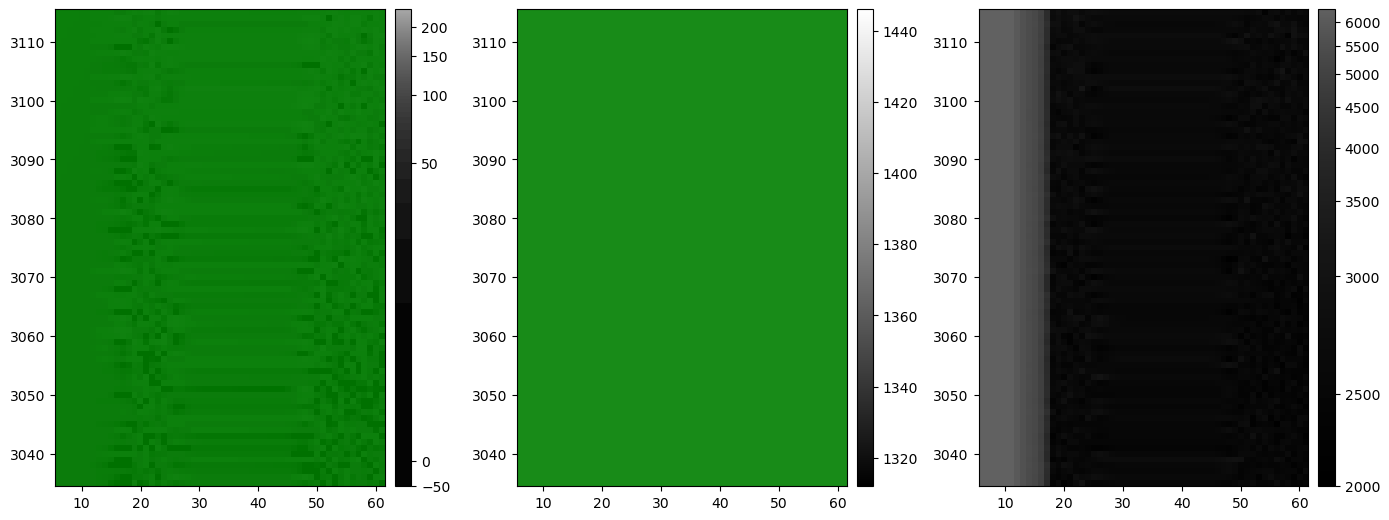

id: 140015933850250
coord_ra: 2.62594 rad
coord_dec: 0.0259475 rad
parent: 0
flags_negative: 0
base_NaiveCentroid_x: -119.387
base_NaiveCentroid_y: 3026.29
base_NaiveCentroid_flag: 1
base_NaiveCentroid_flag_noCounts: 0
base_NaiveCentroid_flag_edge: 1
base_NaiveCentroid_flag_resetToPeak: 0
base_PeakCentroid_x: 24
base_PeakCentroid_y: 3100
base_PeakCentroid_flag: 0
base_SdssCentroid_x: -119.387
base_SdssCentroid_y: 3026.29
base_SdssCentroid_xErr: nan
base_SdssCentroid_yErr: nan
base_SdssCentroid_flag: 1
base_SdssCentroid_flag_edge: 1
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_SdssCentroid_flag_badError: 0
ip_diffim_NaiveDipoleCentroid_flag: 0
ip_diffim_NaiveDipoleCentroid_pos_flag: 0
ip_diffim_NaiveDipoleCentroid_neg_flag: 0
ip_diffim_NaiveDipoleCentroid_x: -119.387
ip_diffim_NaiveDipoleCentroid_y: 3026.29
ip_diffim_NaiveDipoleCentroid_xErr: nan
ip_diffim

In [11]:
registry = butler.registry
dt = registry.getDatasetType('calexp')

afwDisplay.setDefaultBackend('firefly')
datasetType = 'calexp'

plot_footprint(source, datasetType)

When looking at the region the footprint is centered on (if firefly is working)

In [12]:
dataId ={'detector':source['detector'],'visit': source['visit']}
calexp=butler.get('calexp', dataId)
m_and_v_plots(calexp, display_num=0)

Visit:  326 , Detector:  0


In [15]:
calexp.visitInfo.date.get()==source['midPointTai']

True

In [19]:
dataId ={'detector':source['detector'],'visit': source['visit']}
calexp=butler.get('calexp', dataId)
catalog = butler.get(f'fakes_goodSeeingDiff_diaSrc', dataId)
record = catalog.find(source['diaSourceId'])
footprint = record.getFootprint()

In the record you can see that the base_PeakCentroid and the base_SdssCentroid are wildly different in location, and the resetToPeak flag has not been set, despite the two centroids being very far apart.

Checking the location of the peaks.

In [20]:
peaks=footprint.getPeaks()

In [21]:
peaks

<class 'lsst.afw.detection.PeakCatalog'>
 id  f_x   f_y   i_x i_y  peakValue    significance   
     pix   pix   pix pix      ct                      
---- ---- ------ --- ---- --------- ------------------
2495 24.0 3100.0  24 3100 220.96243  44.36871337890625
2494 25.0 3062.0  25 3062 192.46634 38.649532318115234
 579 15.0 3061.0  15 3061  33.32874  5.091574192047119
 573 37.0 3046.0  37 3046 27.690882  5.591167449951172

Checking the footprint size. One question I have is why does this bbox not actually match with the bbox in in the source columns? 

In [22]:
footprint.getBBox()

Box2I(corner=Point2I(6, 3035), dimensions=Extent2I(56, 81))

I looked at both the coordinates in pixels using Firefly and in the ra and dec coordinates to double check if there was something going wrong with the the coordinates.

In [23]:
c = SkyCoord(source.ra, source.decl, unit=(u.deg, u.deg))

In [24]:
print(c.to_string('hmsdms'))

10h01m49.30123092s +01d29m12.05086192s


## Source Two

In [25]:
diaSourceId=153792041451941
source2 = apdbQuery.load_source(diaSourceId)
source2['diaSourceId']==diaSourceId

True

In [26]:
source2

diaSourceId                    153792041451941
ccdVisitId                               71615
diaObjectId                    153792041451941
ssObjectId                                   0
parentDiaSourceId                            0
prv_procOrder                                0
ssObjectReassocTime                       None
midPointTai                       56741.467487
ra                                  149.645005
raErr                                     None
decl                                  1.778654
declErr                                   None
ra_decl_Cov                               None
x                                  1647.458984
xErr                                      None
y                                  4273.828125
yErr                                      None
x_y_Cov                                   None
apFlux                                    None
apFluxErr                                 None
snr                                   5.566566
psFlux       

The blue in the mask shows the region of a detected source. On the image, the footprint is just on the edge of a region flagged CROSSTALK. 

Visit:  358 , Detector:  15


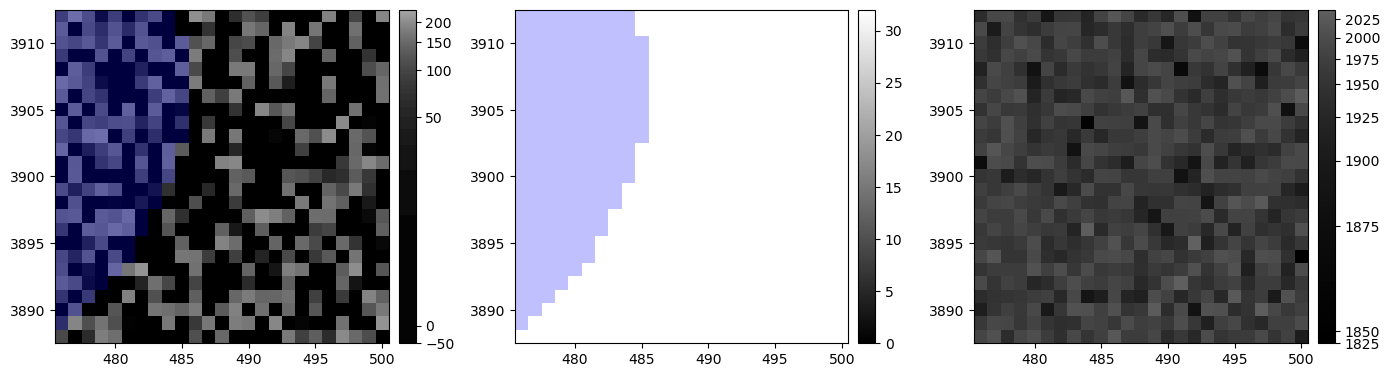

id: 153792041451941
coord_ra: 2.6118 rad
coord_dec: 0.0310434 rad
parent: 0
flags_negative: 0
base_NaiveCentroid_x: 1647.46
base_NaiveCentroid_y: 4273.83
base_NaiveCentroid_flag: 1
base_NaiveCentroid_flag_noCounts: 0
base_NaiveCentroid_flag_edge: 1
base_NaiveCentroid_flag_resetToPeak: 0
base_PeakCentroid_x: 488
base_PeakCentroid_y: 3900
base_PeakCentroid_flag: 0
base_SdssCentroid_x: 1647.46
base_SdssCentroid_y: 4273.83
base_SdssCentroid_xErr: nan
base_SdssCentroid_yErr: nan
base_SdssCentroid_flag: 1
base_SdssCentroid_flag_edge: 1
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_SdssCentroid_flag_badError: 0
ip_diffim_NaiveDipoleCentroid_flag: 0
ip_diffim_NaiveDipoleCentroid_pos_flag: 0
ip_diffim_NaiveDipoleCentroid_neg_flag: 0
ip_diffim_NaiveDipoleCentroid_x: 1647.46
ip_diffim_NaiveDipoleCentroid_y: 4273.83
ip_diffim_NaiveDipoleCentroid_xErr: nan
ip_diffim_Na

In [27]:
plot_footprint(source2, datasetType)

In [28]:
dataId ={'detector':source2['detector'],'visit': source2['visit']}
calexp=butler.get('calexp', dataId)
m_and_v_plots(calexp, display_num=0)

Visit:  358 , Detector:  15


In [29]:
c = SkyCoord(source2.ra, source2.decl, unit=(u.deg, u.deg))
print(c.to_string('hmsdms'))

09h58m34.8011662s +01d46m43.15481108s


## Source Three

In [30]:
diaSourceId=504450351366776
source3 = apdbQuery.load_source(diaSourceId)
source3['diaSourceId']==diaSourceId

True

In [31]:
source3

diaSourceId                    504450351366776
ccdVisitId                              234903
diaObjectId                    504450351366776
ssObjectId                                   0
parentDiaSourceId                            0
prv_procOrder                                0
ssObjectReassocTime                       None
midPointTai                       56744.280429
ra                                  149.322366
raErr                                     None
decl                                  2.669414
declErr                                   None
ra_decl_Cov                               None
x                                  2106.601074
xErr                                      None
y                                  3430.027832
yErr                                      None
x_y_Cov                                   None
apFlux                                    None
apFluxErr                                 None
snr                                   5.047523
psFlux       

This "source" is in a vingetted region where we cannot get good sources from in the first place.

Visit:  1174 , Detector:  103


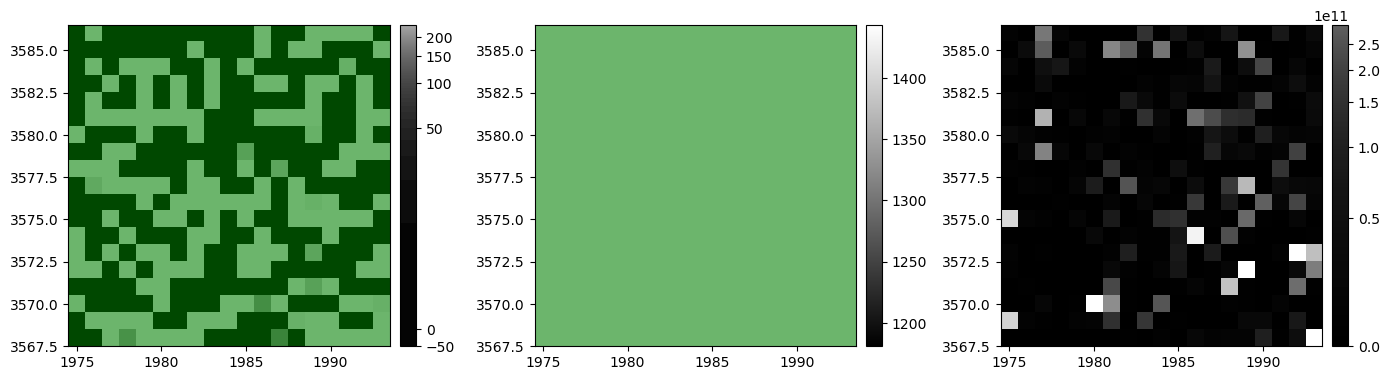

id: 504450351366776
coord_ra: 2.60617 rad
coord_dec: 0.0465901 rad
parent: 0
flags_negative: 0
base_NaiveCentroid_x: 2106.6
base_NaiveCentroid_y: 3430.03
base_NaiveCentroid_flag: 1
base_NaiveCentroid_flag_noCounts: 0
base_NaiveCentroid_flag_edge: 1
base_NaiveCentroid_flag_resetToPeak: 0
base_PeakCentroid_x: 1984
base_PeakCentroid_y: 3577
base_PeakCentroid_flag: 0
base_SdssCentroid_x: 2106.6
base_SdssCentroid_y: 3430.03
base_SdssCentroid_xErr: nan
base_SdssCentroid_yErr: nan
base_SdssCentroid_flag: 1
base_SdssCentroid_flag_edge: 1
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_SdssCentroid_flag_badError: 0
ip_diffim_NaiveDipoleCentroid_flag: 0
ip_diffim_NaiveDipoleCentroid_pos_flag: 0
ip_diffim_NaiveDipoleCentroid_neg_flag: 0
ip_diffim_NaiveDipoleCentroid_x: 2106.6
ip_diffim_NaiveDipoleCentroid_y: 3430.03
ip_diffim_NaiveDipoleCentroid_xErr: nan
ip_diffim_Nai

In [32]:
plot_footprint(source3, datasetType)

In [33]:
dataId ={'detector':source3['detector'],'visit': source3['visit']}
calexp=butler.get('calexp', dataId)
m_and_v_plots(calexp, display_num=0)

Visit:  1174 , Detector:  103


In [34]:
c = SkyCoord(source3.ra, source3.decl, unit=(u.deg, u.deg))
print(c.to_string('hmsdms'))

09h57m17.36776626s +02d40m09.88914575s


## Source Four

Source four was also on a seperate detector/visit

In [35]:
diaSourceId=506009424495146
source4 = apdbQuery.load_source(diaSourceId)
source4['diaSourceId']==diaSourceId

True

In [36]:
source4

diaSourceId                     506009424495146
ccdVisitId                               235629
diaObjectId                    9718697094545760
ssObjectId                                    0
parentDiaSourceId                             0
prv_procOrder                                 0
ssObjectReassocTime                        None
midPointTai                         56744.28774
ra                                   149.381532
raErr                                      None
decl                                   1.830928
declErr                                    None
ra_decl_Cov                                None
x                                    -90.672676
xErr                                       None
y                                    212.251648
yErr                                       None
x_y_Cov                                    None
apFlux                                     None
apFluxErr                                  None
snr                                    5

This was a bad region in general. The brown and red region is a mix of no data/bad data, as well as being in a vignetted region and on the edge fo the detector.

Visit:  1178 , Detector:  29


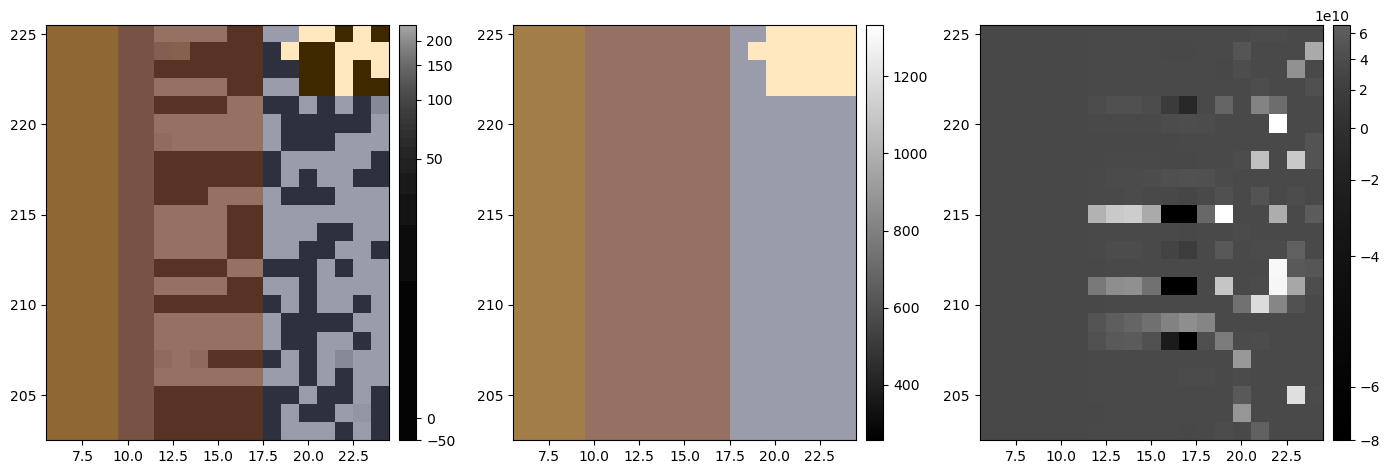

id: 506009424495146
coord_ra: 2.6072 rad
coord_dec: 0.0319557 rad
parent: 0
flags_negative: 0
base_NaiveCentroid_x: -90.6727
base_NaiveCentroid_y: 212.252
base_NaiveCentroid_flag: 1
base_NaiveCentroid_flag_noCounts: 0
base_NaiveCentroid_flag_edge: 1
base_NaiveCentroid_flag_resetToPeak: 0
base_PeakCentroid_x: 15
base_PeakCentroid_y: 212
base_PeakCentroid_flag: 0
base_SdssCentroid_x: -90.6727
base_SdssCentroid_y: 212.252
base_SdssCentroid_xErr: nan
base_SdssCentroid_yErr: nan
base_SdssCentroid_flag: 1
base_SdssCentroid_flag_edge: 1
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_SdssCentroid_flag_badError: 0
ip_diffim_NaiveDipoleCentroid_flag: 0
ip_diffim_NaiveDipoleCentroid_pos_flag: 0
ip_diffim_NaiveDipoleCentroid_neg_flag: 0
ip_diffim_NaiveDipoleCentroid_x: -90.6727
ip_diffim_NaiveDipoleCentroid_y: 212.252
ip_diffim_NaiveDipoleCentroid_xErr: nan
ip_diffim_N

In [37]:
plot_footprint(source4, datasetType)

In [38]:
dataId ={'detector':source4['detector'],'visit': source4['visit']}
calexp=butler.get('calexp', dataId)
m_and_v_plots(calexp, display_num=0)

Visit:  1178 , Detector:  29


## Source Five

In [39]:
diaSourceId=506831910732048
source5 = apdbQuery.load_source(diaSourceId)
source5['diaSourceId']==diaSourceId

True

This is the only source of the five examples that looks like a good source.There is nothing strange going on around this source, so the runaway centroid is a mystery.

Visit:  1180 , Detector:  12


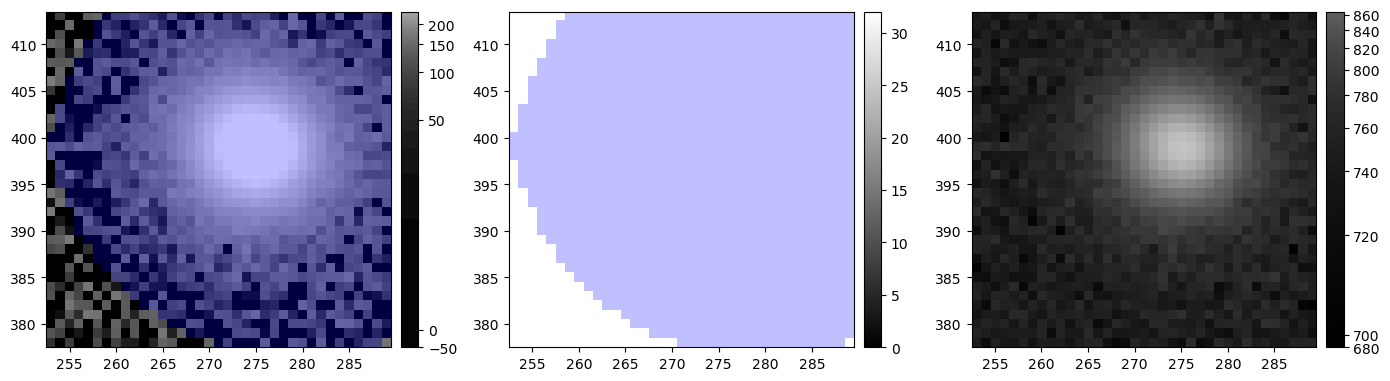

id: 506831910732048
coord_ra: 2.62246 rad
coord_dec: 0.0293017 rad
parent: 0
flags_negative: 0
base_NaiveCentroid_x: -296.011
base_NaiveCentroid_y: 830.432
base_NaiveCentroid_flag: 1
base_NaiveCentroid_flag_noCounts: 0
base_NaiveCentroid_flag_edge: 1
base_NaiveCentroid_flag_resetToPeak: 0
base_PeakCentroid_x: 272
base_PeakCentroid_y: 387
base_PeakCentroid_flag: 0
base_SdssCentroid_x: -296.011
base_SdssCentroid_y: 830.432
base_SdssCentroid_xErr: nan
base_SdssCentroid_yErr: nan
base_SdssCentroid_flag: 1
base_SdssCentroid_flag_edge: 1
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_SdssCentroid_flag_badError: 0
ip_diffim_NaiveDipoleCentroid_flag: 0
ip_diffim_NaiveDipoleCentroid_pos_flag: 0
ip_diffim_NaiveDipoleCentroid_neg_flag: 0
ip_diffim_NaiveDipoleCentroid_x: -296.011
ip_diffim_NaiveDipoleCentroid_y: 830.432
ip_diffim_NaiveDipoleCentroid_xErr: nan
ip_diffim

In [40]:
plot_footprint(source5, datasetType)

In [41]:
dataId ={'detector':source5['detector'],'visit': source5['visit']}
calexp=butler.get('calexp', dataId)
m_and_v_plots(calexp, display_num=0)

Visit:  1180 , Detector:  12


## Looking at Bounding Boxes

Bounding box histogram of 100000 sources. Currently the problem sources have bbox sizes of around 50, which seems slightly larger than normal but there are other identified sources with larger bbox sizes.

(array([17407., 53795., 18329.,  5680.,  2247.,  1185.,   540.,   310.,
          188.,   135.]),
 array([ 10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91., 100.]),
 <BarContainer object of 10 artists>)

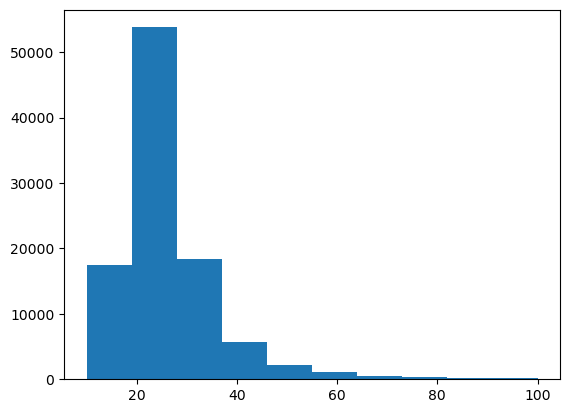

In [42]:
plt.hist(sources.bboxSize, range=[10,100])

In [43]:
np.mean(sources.bboxSize)

25.83705

In [44]:
max(sources.bboxSize)

331

In [45]:
large_bbox=sources.iloc[np.where(sources.bboxSize >= 200)]
path_manager = PathManager("/sdf/group/rubin/u/parejko/scratch/cutouts", chunk_size=10000)

I looked at extremely large bbox sizes, but it doesn't seem like runaway bbox sizes nevessarily indicate a bad source as several do look like real sources in this set.

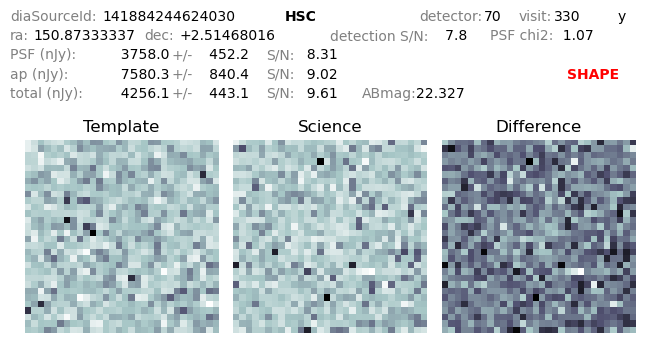

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=150.8733333744028+2.5146801623733523&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
241


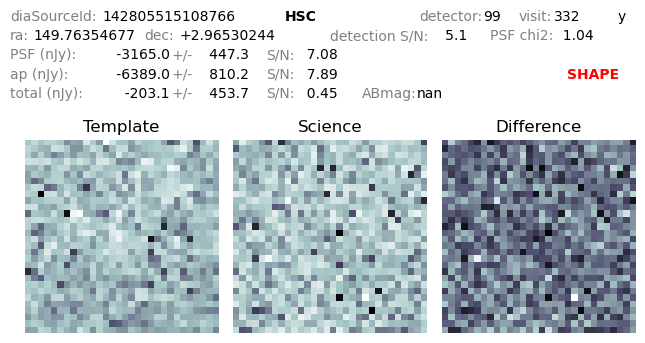

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.7635467653916+2.9653024396743817&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
256


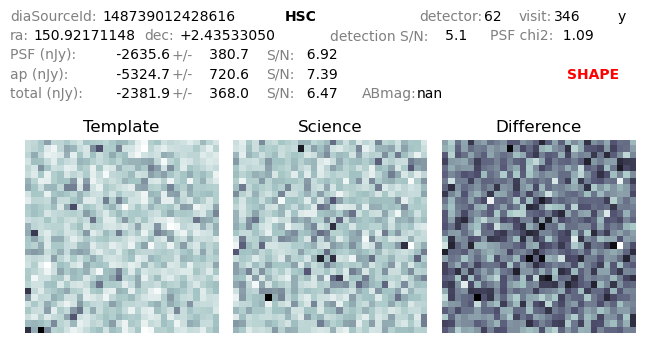

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=150.921711484561+2.435330499616303&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
302


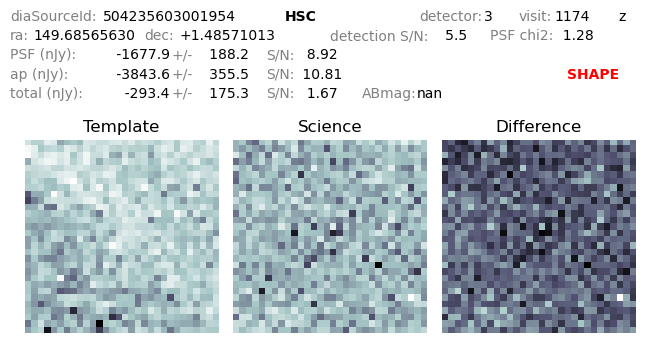

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.68565630243813+1.4857101267949715&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
222


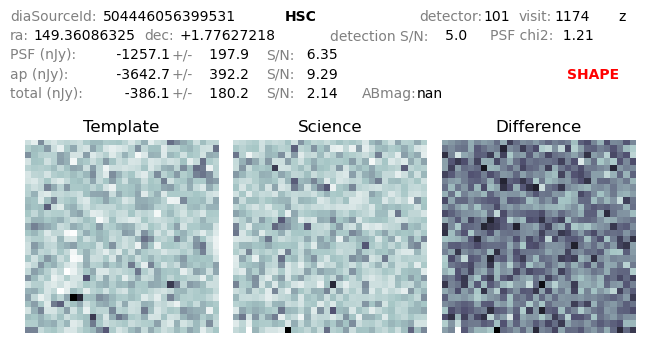

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.36086325009381+1.7762721833197923&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

244


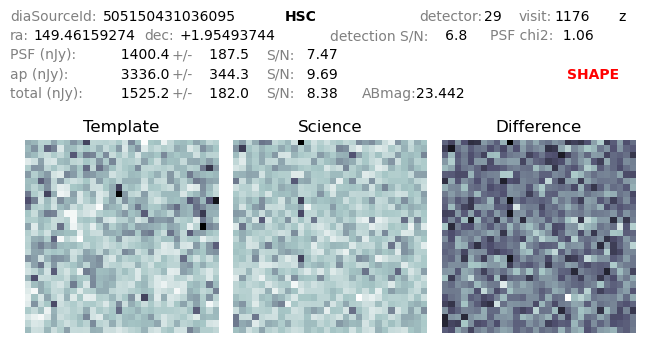

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.46159274218263+1.9549374360797844&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
205


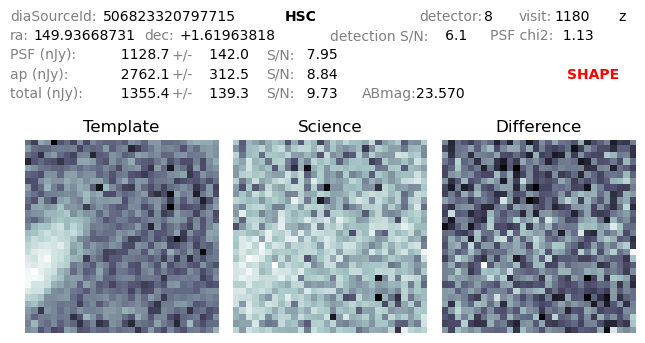

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.93668731020915+1.6196381782908502&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

223


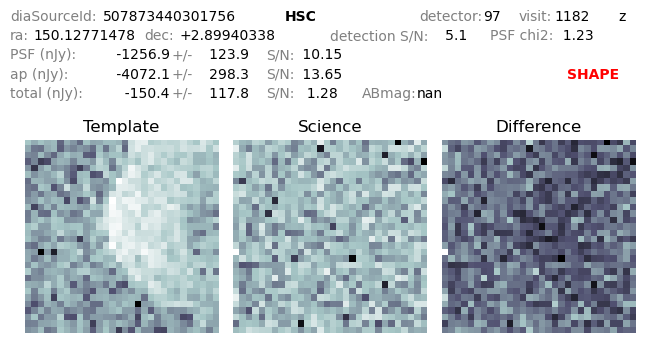

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=150.1277147820866+2.8994033762045133&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
267


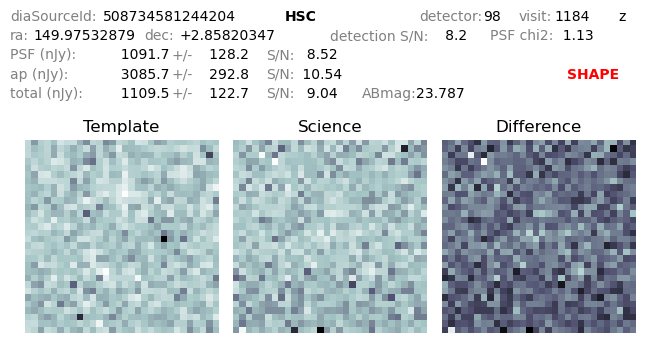

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.97532878826127+2.858203474474122&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
266


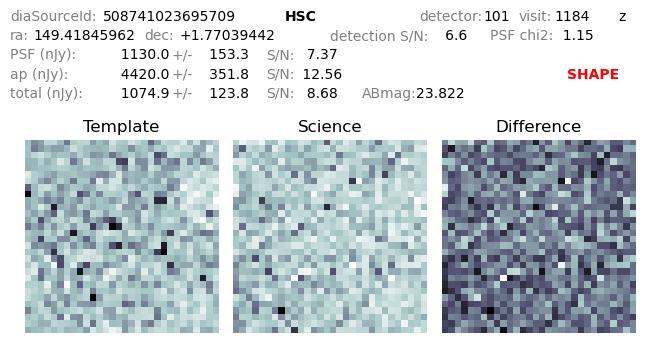

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.41845962326778+1.7703944235453262&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

253


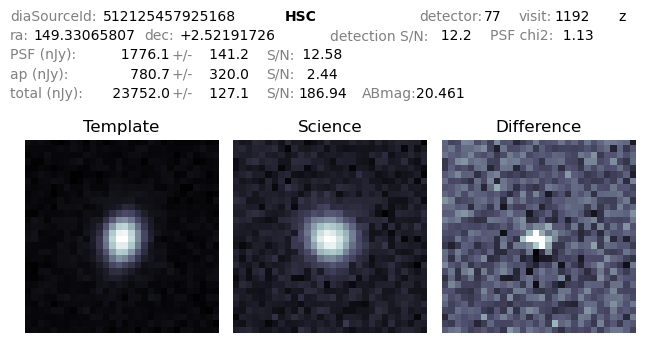

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.33065806748778+2.5219172550087228&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
331


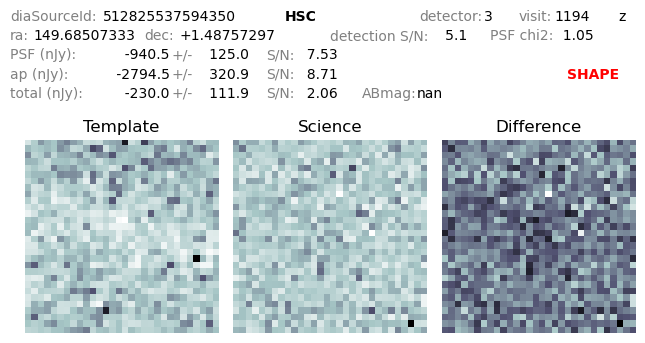

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.68507333244213+1.4875729747617423&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
315


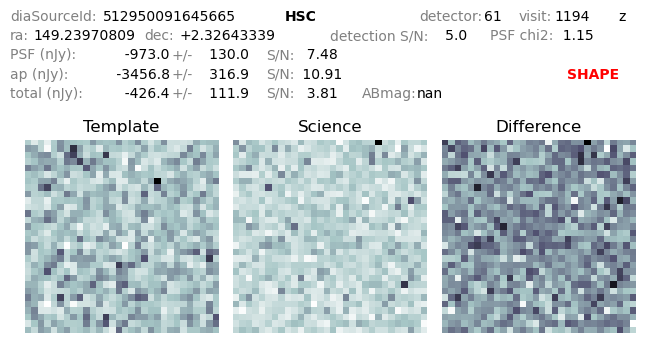

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.23970809316893+2.3264333858132122&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
210


In [46]:
for index, source in large_bbox.iterrows():
    single_path = path_manager(source['diaSourceId'])
    display(Image(single_path))
    make_simbad_link(source['ra'], source['decl'])
    print(source['bboxSize'])

## Filters

I looked to see if the issue was filter specific and it did not appear that way.

In [47]:
source.filterName

'z'

In [48]:
source2.filterName

'y'

In [49]:
source3.filterName

'z'

In [50]:
source4.filterName

'z'

In [51]:
source5.filterName

'z'